FIN 556 

Blaine Hill

This notebook predicts the next bid1/ask1 by using kalman filter

[This resource](https://tjosh.medium.com/kalman-filter-predict-measure-update-repeat-20a5e618be66) was consulted and used in the making of this notebook

Both a mathematical implemenation of Kalman Filter and a library implmentation were used

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter
from scipy.stats import norm


import sys
sys.path.append('..')
from proc_analysis import proc_funcs


In [2]:
data_dir = "/Users/blaineh2/Desktop/FIN 556/data/orderbook_trade_SPY_AAL/"
data_files = proc_funcs.get_book_updates_files(data_dir)
print(data_files)

['20230105_book_updates.csv']


In [3]:
query_ticker, query_date = 'SPY', '20230105' #hardcoded this example for this notebook
book = proc_funcs.build_order_book_series(query_date, [query_date], data_dir)

In [4]:
# Load data
# contains [Collection Time, Ticker Symbol, Bid Prices, Bid Sizes, Ask Prices, Ask Sizes]
df = pd.DataFrame(book, columns=['timestamp', 'symbol', 'bid_price', 'bid_size', 'ask_price', 'ask_size'])

#Convert lists to columns
# df['timestamp'] = pd.to_datetime(df['timestamp']).astype(np.int64)
df['bid_price1'] = df['bid_price'].apply(lambda x: x[0])
df['bid_price2'] = df['bid_price'].apply(lambda x: x[1] if len(x) > 1 else np.nan)
df['bid_price3'] = df['bid_price'].apply(lambda x: x[2] if len(x) > 2 else np.nan)
df['bid_size1'] = df['bid_size'].apply(lambda x: x[0])  
df['bid_size2'] = df['bid_size'].apply(lambda x: x[1] if len(x) > 1 else np.nan)
df['bid_size3'] = df['bid_size'].apply(lambda x: x[2] if len(x) > 2 else np.nan)
df['ask_price1'] = df['ask_price'].apply(lambda x: x[0])
df['ask_price2'] = df['ask_price'].apply(lambda x: x[1] if len(x) > 1 else np.nan) 
df['ask_price3'] = df['ask_price'].apply(lambda x: x[2] if len(x) > 2 else np.nan)
df['ask_size1'] = df['ask_size'].apply(lambda x: x[0])
df['ask_size2'] = df['ask_size'].apply(lambda x: x[1] if len(x) > 1 else np.nan)
df['ask_size3'] = df['ask_size'].apply(lambda x: x[2] if len(x) > 2 else np.nan)
df = df[df['symbol'] == 'SPY'] 
df = df.drop(['bid_price', 'bid_size', 'ask_price', 'ask_size'], axis=1)
df2 = df.copy()

print(df.head())

                        timestamp symbol  bid_price1  bid_price2  bid_price3  \
21  2023-01-05 14:30:01.000965120    SPY      375.00       370.0       361.0   
22  2023-01-05 14:30:01.003010048    SPY      375.00       370.0       361.0   
23  2023-01-05 14:30:01.009089024    SPY      375.00       370.0       361.0   
24  2023-01-05 14:30:01.009997056    SPY      375.00       370.0       361.0   
25  2023-01-05 14:30:01.009997056    SPY      381.59       375.0       370.0   

    bid_size1  bid_size2  bid_size3  ask_price1  ask_price2  ask_price3  \
21     1621.0      338.0      546.0      381.69      381.73      458.06   
22     1621.0      338.0      546.0      381.69      381.73      400.00   
23     1621.0      338.0      546.0      381.69      381.73      400.00   
24     1621.0      338.0      546.0      381.73      400.00      458.06   
25      200.0     1621.0      338.0      381.73      400.00      458.06   

    ask_size1  ask_size2  ask_size3  
21      200.0        1.0      

In [5]:
def kalman_filter(x, P, F, Q, H, R, z):
    # pred next timestep estimate for x and P
    x_hat = F @ x
    P_hat = F @ P @ (F.T + Q)

    # update
    K = P_hat @ H.T @ np.linalg.inv(H @ P_hat @ H.T + R)
    x = x_hat + K @ (z - H @ x_hat)
    P = (np.eye(len(x)) - K @ H) @ P_hat

    return x, P


In [6]:
# Initial state
x_init = np.array([0, 0])

# Initial state covariance matrix
P_init = np.eye(2) * 1e-3

# System transition matrix (assuming a simple constant velocity model)
F = np.eye(2)

# Measurement noise covariance matrix
Q = np.eye(2) * 1e-3

# Measurement matrix (identity matrix, as we directly observe bid1 and ask1)
H = np.eye(2)

# Measurement noise covariance matrix
R = np.eye(2) * 1e-3

In [7]:
x = x_init
P = P_init

for index, row in tqdm(df.iterrows()):
    z = np.array([row['bid_price1'], row['ask_price1']])
    x, P = kalman_filter(x, P, F, Q, H, R, z)

    df.at[index, 'predicted_bid1'] = x[0]
    df.at[index, 'predicted_ask1'] = x[1]
    df.at[index, 'std_bid1'] = np.std(P[0,0])
    df.at[index, 'std_ask1'] = np.std(P[1,1])

# Error between true value and prediction
df['bid_error'] = df['bid_price1'] - df['predicted_bid1']
df['ask_error'] = df['ask_price1'] - df['predicted_ask1']

print(df.head())

1128646it [03:11, 5892.52it/s]

                        timestamp symbol  bid_price1  bid_price2  bid_price3  \
21  2023-01-05 14:30:01.000965120    SPY      375.00       370.0       361.0   
22  2023-01-05 14:30:01.003010048    SPY      375.00       370.0       361.0   
23  2023-01-05 14:30:01.009089024    SPY      375.00       370.0       361.0   
24  2023-01-05 14:30:01.009997056    SPY      375.00       370.0       361.0   
25  2023-01-05 14:30:01.009997056    SPY      381.59       375.0       370.0   

    bid_size1  bid_size2  bid_size3  ask_price1  ask_price2  ask_price3  \
21     1621.0      338.0      546.0      381.69      381.73      458.06   
22     1621.0      338.0      546.0      381.69      381.73      400.00   
23     1621.0      338.0      546.0      381.69      381.73      400.00   
24     1621.0      338.0      546.0      381.73      400.00      458.06   
25      200.0     1621.0      338.0      381.73      400.00      458.06   

    ask_size1  ask_size2  ask_size3  predicted_bid1  predicted_ask1 

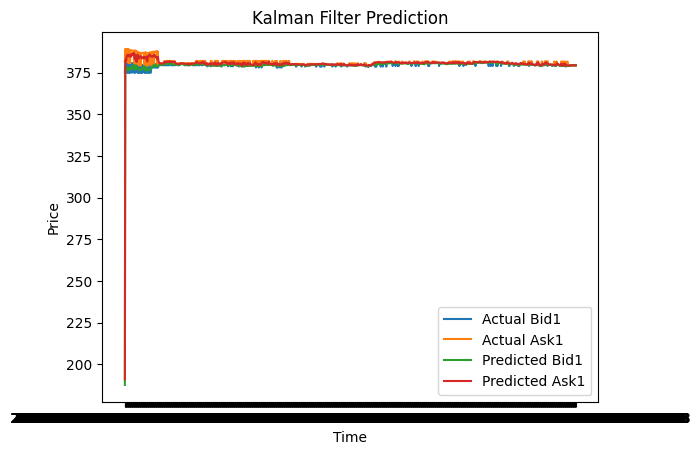

In [8]:
downsample_factor = 1000
df = df.iloc[::downsample_factor]

plt.plot(df['timestamp'], df['bid_price1'], label='Actual Bid1')
plt.plot(df['timestamp'], df['ask_price1'], label='Actual Ask1')
plt.plot(df['timestamp'], df['predicted_bid1'], label='Predicted Bid1')
plt.plot(df['timestamp'], df['predicted_ask1'], label='Predicted Ask1')
plt.xlabel('Time')  
plt.ylabel('Price')
plt.title('Kalman Filter Prediction')   
plt.legend()
plt.savefig('/Users/blaineh2/Desktop/FIN 556/group_03_project/kf_svi_pred/your_figure1.svg', format='svg')
plt.show()


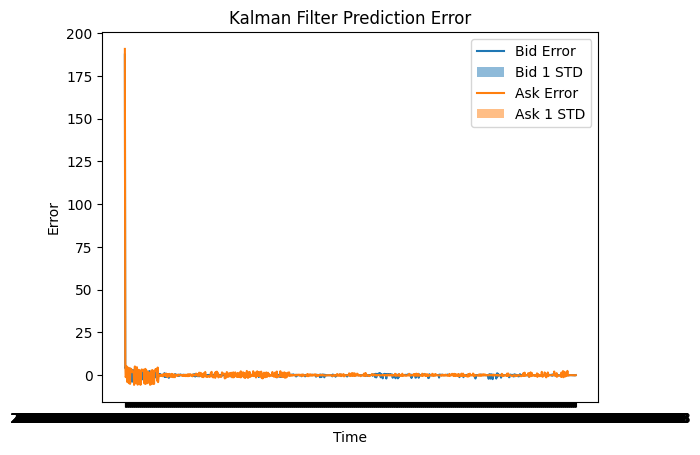

In [9]:
plt.plot(df['timestamp'], df['bid_error'], label='Bid Error')
plt.fill_between(df['timestamp'], 
                 df['bid_error']-df['std_bid1'], 
                 df['bid_error']+df['std_bid1'],
                 alpha=0.5, label='Bid 1 STD')
plt.plot(df['timestamp'], df['ask_error'], label='Ask Error')
plt.fill_between(df['timestamp'],  
                 df['ask_error']-df['std_ask1'],
                 df['ask_error']+df['std_ask1'], 
                 alpha=0.5, label='Ask 1 STD')
plt.legend()
plt.xlabel('Time')  
plt.ylabel('Error')
plt.title('Kalman Filter Prediction Error')    
plt.savefig('/Users/blaineh2/Desktop/FIN 556/group_03_project/kf_svi_pred/your_figure2.svg', format='svg')
plt.show()


In [10]:
# Initialize KalmanFilter
kf = KalmanFilter(dim_x=2, dim_z=2)
kf.F = np.eye(2)  # 2x2 identity matrix as transition matrix
kf.H = np.array([[1, 0], [0, 1]])  # 2x2 identity matrix as observation matrix
kf.x = np.array([0, 0])  # initial state mean
kf.P *= np.eye(2)  # initial state covariance
kf.R = 1e-3 * np.eye(2)  # observation covariance



# Apply Kalman Filter
for index, row in tqdm(df2.iterrows()):
    z = np.array([[row['bid_price1'], row['ask_price1']]])

    kf.predict()
    kf.update(z)

    df2.at[index, 'predicted_bid1'] = kf.x[0]
    df2.at[index, 'predicted_ask1'] = kf.x[1]
    df2.at[index, 'std_bid1'] = np.std(kf.P[0,0])
    df2.at[index, 'std_ask1'] = np.std(kf.P[1,1])

# Error between true value and prediction
df2['bid_error'] = df2['bid_price1'] - df2['predicted_bid1']
df2['ask_error'] = df2['ask_price1'] - df2['predicted_ask1']  

1128646it [03:23, 5550.09it/s]


In [11]:
print(df.head())

                          timestamp symbol  bid_price1  bid_price2  \
21    2023-01-05 14:30:01.000965120    SPY      375.00       370.0   
1091  2023-01-05 14:30:09.639357952    SPY      381.70       375.0   
2413  2023-01-05 14:30:25.600635904    SPY      381.53       375.0   
3668  2023-01-05 14:30:32.995118080    SPY      381.61       375.0   
4908  2023-01-05 14:30:49.827653888    SPY      381.55       375.0   

      bid_price3  bid_size1  bid_size2  bid_size3  ask_price1  ask_price2  \
21        361.00     1621.0      338.0      546.0      381.69      381.73   
1091      373.93      100.0     1621.0      100.0      389.25      400.00   
2413      373.87      100.0     1621.0      100.0      381.75      389.17   
3668      373.87      100.0     1621.0      100.0      381.65      381.75   
4908      373.87      200.0     1621.0      100.0      389.17      400.00   

      ask_price3  ask_size1  ask_size2  ask_size3  predicted_bid1  \
21        458.06      200.0        1.0      100

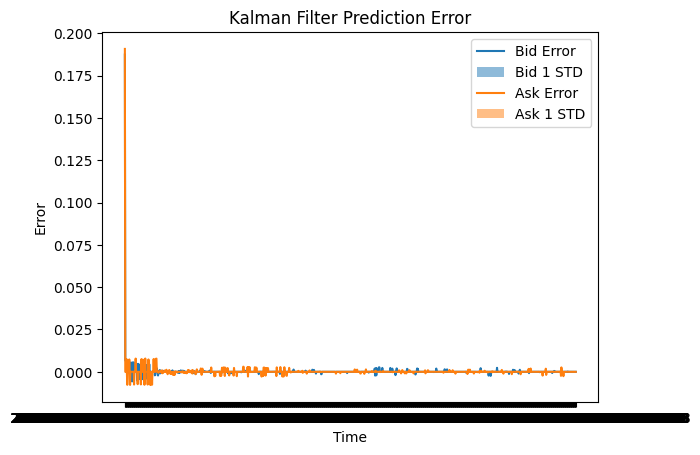

In [12]:
# # Plot results with confidence intervals
# plt.plot(df['timestamp'], df['bid_price1'], label='Actual Bid1')
# plt.plot(df['timestamp'], df['ask_price1'], label='Actual Ask1')
# plt.plot(df['timestamp'], df['predicted_bid1'], label='Predicted Bid1')
# plt.plot(df['timestamp'], df['predicted_ask1'], label='Predicted Ask1')
# plt.fill_between(df['timestamp'], df['lower_bound_bid'], df['upper_bound_bid'], color='b', alpha=1, label='95% CI Bid1')
# plt.fill_between(df['timestamp'], df['lower_bound_ask'], df['upper_bound_ask'], color='y', alpha=1, label='95% CI Ask1')
# plt.legend()
# plt.show()

df2 = df2.iloc[::downsample_factor]

plt.plot(df2['timestamp'], df2['bid_error'], label='Bid Error')
plt.fill_between(df2['timestamp'], 
                 df2['bid_error']-df2['std_bid1'], 
                 df2['bid_error']+df2['std_bid1'],
                 alpha=0.5, label='Bid 1 STD')
plt.plot(df2['timestamp'], df2['ask_error'], label='Ask Error')
plt.fill_between(df2['timestamp'],  
                 df2['ask_error']-df2['std_ask1'],
                 df2['ask_error']+df2['std_ask1'], 
                 alpha=0.5, label='Ask 1 STD')
plt.legend()
plt.xlabel('Time')  
plt.ylabel('Error')
plt.title('Kalman Filter Prediction Error')    
plt.savefig('/Users/blaineh2/Desktop/FIN 556/group_03_project/kf_svi_pred/your_figure3.svg', format='svg')
plt.show()
